### Importing liberies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files

import os
import cv2
import torch

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

%matplotlib inline
#matplotlib.rcParams['figure.facecolor'] = '#ffffff'

#ignoring warning 
import warnings
warnings.filterwarnings('ignore')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/content/drive/MyDrive/DATA/eye_drowsiness_dataset'

### Exploring dataset

In [ ]:
print(os.listdir(data_dir))
train_classes = os.listdir(data_dir + "/train")
print(train_classes)
test_classes = os.listdir(data_dir + "/test")
print(test_classes)

['test', 'train']
['Open', 'yawn', 'no_yawn', 'Closed']
['Open', 'no_yawn', 'yawn', 'Closed']


In [ ]:
train_images = 0
for i in range(len(train_classes)):
  s = train_classes[i] + '_images'
  s = os.listdir(data_dir + "/train/" + train_classes[i])
  print('No. of training examples for', train_classes[i], ': ', len(s))
  train_images += len(s)
  #print(s[:5])

print("\n\nTotal no. of training images : ",train_images)

No. of training examples for Open :  617
No. of training examples for yawn :  626
No. of training examples for no_yawn :  618
No. of training examples for Closed :  617


Total no. of training images :  2478


In [ ]:
test_images = 0
for i in range(len(test_classes)):
  s = test_classes[i] + '_images'
  s = os.listdir(data_dir + "/test/" + test_classes[i])
  print('No. of testing dataset examples for', test_classes[i], ': ', len(s))
  test_images += len(s)
  #print(s[:5])

print("\n\nTotal no. of test images : ",test_images)

No. of testing dataset examples for Open :  109
No. of testing dataset examples for no_yawn :  109
No. of testing dataset examples for yawn :  106
No. of testing dataset examples for Closed :  109


Total no. of test images :  433


Thus it is clear that in eye_drowsiness_dataset folder we have two subfolders train and test in which further 4 subfolders(Open,no_yawn,yawn,Closed) are present, all images are approxmatly equal, so dataset is balance.

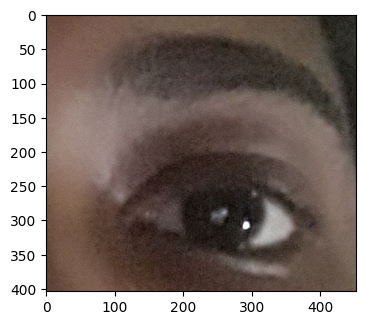

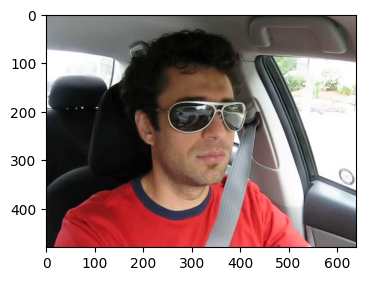

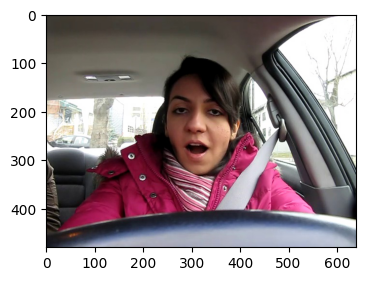

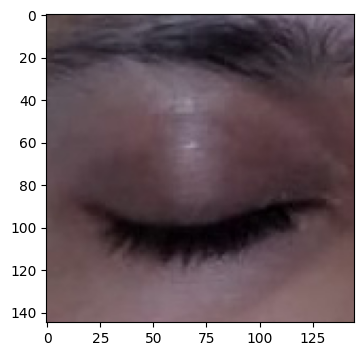

In [ ]:
#showing one image for each training class

def show_image(image_folder_path):
  for i in range(len(train_classes)):
    s = os.listdir(image_folder_path + '/' + test_classes[i])
    for j in range(len(s)):
      image_path  = image_folder_path + test_classes[i] +'/'+ s[j]
      image=plt.imread(image_path)
      fig=plt.figure(figsize=(4,4))
      plt.imshow(image)
      break
    continue


show_image(data_dir+'/train/')

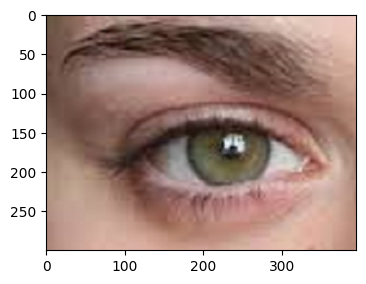

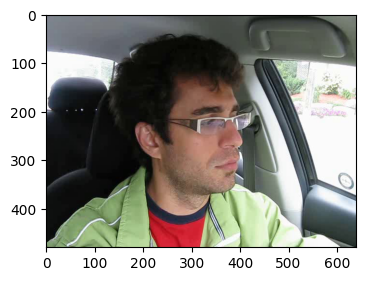

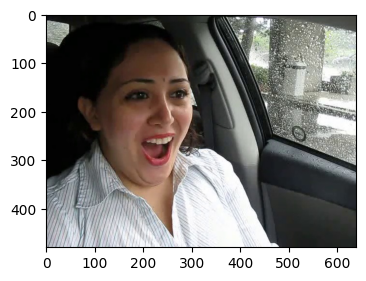

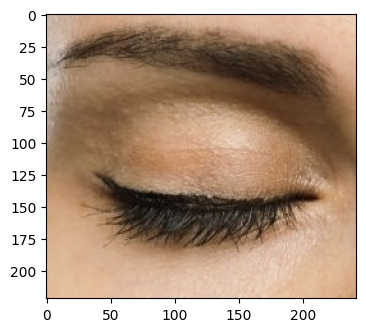

In [ ]:
#showing one image for each test class

show_image(data_dir+'/test/')

### DATA PREPROCESSING

In [ ]:
class CFG:
  batch_size = 16
  size = 256

In [ ]:
#function to load images 

def load_images(directory):
    images = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in tqdm(os.listdir(directory+category)):
            image_path = os.path.join(directory,category,filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            images.append(image)
            labels.append(category)
    
    images = np.array(images,dtype='float32')
    return images, labels


#loading dataset
print('*******Loading Train Data*******')
train_ds = load_images(data_dir + '/train/' )
print('*******Loading Test Data*******')
test_ds = load_images(data_dir + '/test/')

*******Loading Train Data*******


  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/626 [00:00<?, ?it/s]

  0%|          | 0/618 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

*******Loading Test Data*******


  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

In [ ]:
x_train,y_train = train_ds
x_test,y_test =  test_ds

In [ ]:
#Normalizing train dataset

layer = layers.Normalization()
layer.adapt(x_train)
x_train = layer(x_train)

#Normalizing test dataset

layer = layers.Normalization()
layer.adapt(x_test)
x_test = layer(x_test)

In [ ]:
print(y_train[:5])

['Open', 'Open', 'Open', 'Open', 'Open']


In [ ]:
#label encoding for y_train and y_test


encoder = LabelEncoder()
y_train_ = encoder.fit_transform(y_train)
ytrain_map = dict(zip(y_train, y_train_))  # get the mapping between the original labels and encoded labels
y_test_ = encoder.transform(y_test)
ytest_map =  dict(zip(y_test, y_test_))  # get the mapping between the original labels and encoded labels
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)

In [ ]:
ytrain_map

{'Open': 1, 'yawn': 3, 'no_yawn': 2, 'Closed': 0}

In [ ]:
ytest_map

{'Open': 1, 'no_yawn': 2, 'yawn': 3, 'Closed': 0}

### MODEL

In [ ]:
## Lets define Drowsiness model 


Drowsiness_detection = tf.keras.models.Sequential([

  layers.Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=(224,224,3)),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same'),
  layers.MaxPooling2D(pool_size=2),
  layers.BatchNormalization(),
  layers.Dropout(0.5),

  layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.BatchNormalization(),
  layers.Dropout(0.2),

  layers.Conv2D(filters=128,kernel_size=3,activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.BatchNormalization(),
  layers.Dropout(0.25),

  layers.Flatten(),

  layers.Dense(units=128,activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.25),

  layers.Dense(units=4,activation='softmax')
])

In [ ]:
Drowsiness_detection.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 32)       128       
 ormalization)                                                   
                                                        

In [ ]:
#defining attributes of Model

Drowsiness_detection.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
early_stopping = EarlyStopping(monitor='test_accuracy',patience=20,mode='max',
                                                        verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='test_accuracy',patience=5,mode='max',verbose=1,factor=0.1,min_lr=0.001)

In [ ]:
#saving model and it's parameters


checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,
                    monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

In [ ]:
#training the model

model = Drowsiness_detection.fit(x=x_train,
            y=y_train,
            epochs=20,
            batch_size=16,
            validation_data=(x_test,y_test),
            callbacks=[early_stopping,reduce_lr,model_checkpoint],
            )

Epoch 1/20
155/155 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.7341


Epoch 1: val_accuracy improved from -inf to 0.27252, saving model to checkpoint/
155/155 [==============================] - 21s 34ms/step - loss: 0.5980 - accuracy: 0.7341 - val_loss: 5.0441 - val_accuracy: 0.2725 - lr: 0.0010
Epoch 2/20
155/155 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.8236


Epoch 2: val_accuracy improved from 0.27252 to 0.41339, saving model to checkpoint/
155/155 [==============================] - 5s 33ms/step - loss: 0.4173 - accuracy: 0.8236 - val_loss: 3.3286 - val_accuracy: 0.4134 - lr: 0.0010
Epoch 3/20
154/155 [============================>.] - ETA: 0s - loss: 0.2824 - accuracy: 0.8843


Epoch 3: val_accuracy improved from 0.41339 to 0.52194, saving model to checkpoint/
155/155 [==============================] - 5s 30ms/step - loss: 0.2865 - accuracy: 0.8830 - val_loss: 1.1854 - val_accuracy: 0.5219 - lr: 0.0010
Epoch 4/20
153/155 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9130


Epoch 4: val_accuracy improved from 0.52194 to 0.83141, saving model to checkpoint/
155/155 [==============================] - 4s 27ms/step - loss: 0.2351 - accuracy: 0.9132 - val_loss: 0.4353 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 5/20
154/155 [============================>.] - ETA: 0s - loss: 0.1758 - accuracy: 0.9355


Epoch 5: val_accuracy improved from 0.83141 to 0.84527, saving model to checkpoint/
155/155 [==============================] - 4s 28ms/step - loss: 0.1758 - accuracy: 0.9354 - val_loss: 0.4102 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 6/20
155/155 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9415


Epoch 6: val_accuracy did not improve from 0.84527
155/155 [==============================] - 5s 30ms/step - loss: 0.1618 - accuracy: 0.9415 - val_loss: 0.6550 - val_accuracy: 0.6859 - lr: 0.0010
Epoch 7/20
154/155 [============================>.] - ETA: 0s - loss: 0.1496 - accuracy: 0.9456


Epoch 7: val_accuracy improved from 0.84527 to 0.88684, saving model to checkpoint/
155/155 [==============================] - 4s 28ms/step - loss: 0.1496 - accuracy: 0.9455 - val_loss: 0.2658 - val_accuracy: 0.8868 - lr: 0.0010
Epoch 8/20
154/155 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9554


Epoch 8: val_accuracy improved from 0.88684 to 0.97460, saving model to checkpoint/
155/155 [==============================] - 4s 28ms/step - loss: 0.1192 - accuracy: 0.9548 - val_loss: 0.0853 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 9/20
154/155 [============================>.] - ETA: 0s - loss: 0.1026 - accuracy: 0.9639


Epoch 9: val_accuracy improved from 0.97460 to 0.98614, saving model to checkpoint/
155/155 [==============================] - 5s 30ms/step - loss: 0.1023 - accuracy: 0.9641 - val_loss: 0.0583 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 10/20
153/155 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9657


Epoch 10: val_accuracy did not improve from 0.98614
155/155 [==============================] - 4s 26ms/step - loss: 0.0980 - accuracy: 0.9657 - val_loss: 0.0589 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 11/20
154/155 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9708


Epoch 11: val_accuracy did not improve from 0.98614
155/155 [==============================] - 4s 27ms/step - loss: 0.0758 - accuracy: 0.9709 - val_loss: 0.1667 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 12/20
153/155 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9706


Epoch 12: val_accuracy did not improve from 0.98614
155/155 [==============================] - 5s 30ms/step - loss: 0.0871 - accuracy: 0.9705 - val_loss: 0.1943 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 13/20
153/155 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9755


Epoch 13: val_accuracy did not improve from 0.98614
155/155 [==============================] - 4s 27ms/step - loss: 0.0729 - accuracy: 0.9758 - val_loss: 0.1111 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 14/20
153/155 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.9804


Epoch 14: val_accuracy did not improve from 0.98614
155/155 [==============================] - 4s 27ms/step - loss: 0.0612 - accuracy: 0.9806 - val_loss: 0.0839 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 15/20
154/155 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9809


Epoch 15: val_accuracy did not improve from 0.98614
155/155 [==============================] - 5s 30ms/step - loss: 0.0547 - accuracy: 0.9806 - val_loss: 0.0424 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 16/20
153/155 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9796


Epoch 16: val_accuracy improved from 0.98614 to 0.99076, saving model to checkpoint/
155/155 [==============================] - 4s 28ms/step - loss: 0.0666 - accuracy: 0.9794 - val_loss: 0.0415 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 17/20
153/155 [============================>.] - ETA: 0s - loss: 0.0422 - accuracy: 0.9853


Epoch 17: val_accuracy did not improve from 0.99076
155/155 [==============================] - 4s 27ms/step - loss: 0.0420 - accuracy: 0.9855 - val_loss: 0.0369 - val_accuracy: 0.9885 - lr: 0.0010
Epoch 18/20
154/155 [============================>.] - ETA: 0s - loss: 0.0594 - accuracy: 0.9789


Epoch 18: val_accuracy did not improve from 0.99076
155/155 [==============================] - 5s 30ms/step - loss: 0.0592 - accuracy: 0.9790 - val_loss: 0.0361 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 19/20
155/155 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9843


Epoch 19: val_accuracy did not improve from 0.99076
155/155 [==============================] - 4s 28ms/step - loss: 0.0520 - accuracy: 0.9843 - val_loss: 0.0400 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 20/20
154/155 [============================>.] - ETA: 0s - loss: 0.0408 - accuracy: 0.9874


Epoch 20: val_accuracy did not improve from 0.99076
155/155 [==============================] - 4s 27ms/step - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.0554 - val_accuracy: 0.9792 - lr: 0.0010


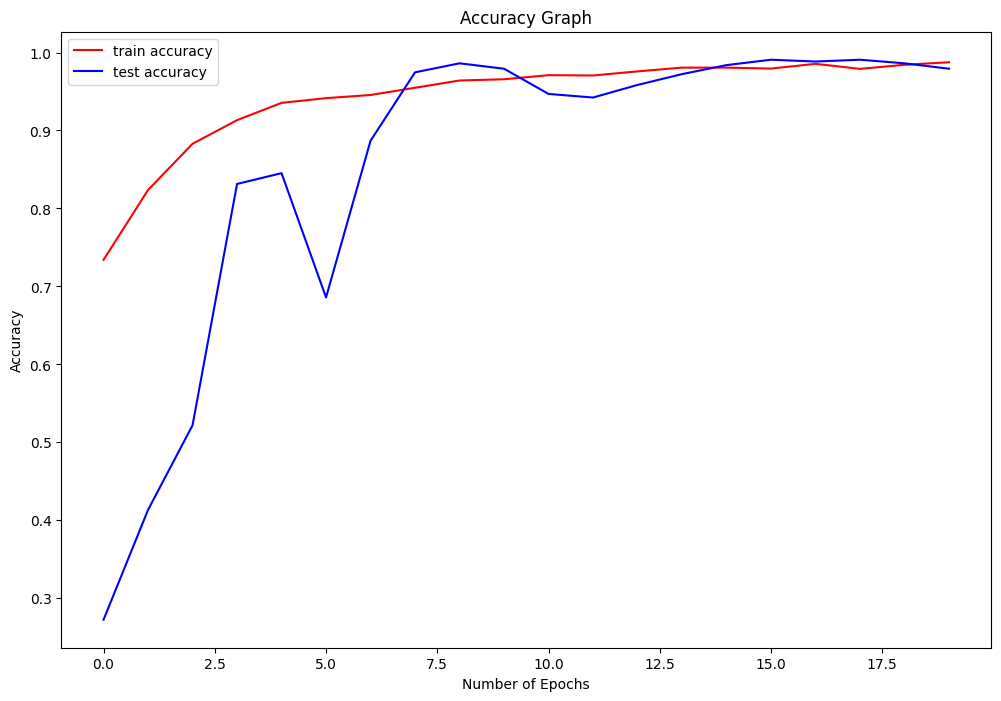

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(model.history['accuracy'],'r',label='train accuracy')
plt.plot(model.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

In [ ]:
Drowsiness_detection.load_weights(checkpoint_filename)

In [ ]:
Drowsiness_detection.save(filepath='drowsiness_detector.model',save_format='h5')
model_ = load_model(filepath='drowsiness_detector.model')
model_

In [ ]:
def predict_on_browse_image(model):
  uploaded_image = files.upload()

  for fn in uploaded_image.keys():
      # predicting images
      path = fn
      
      #preprocessing image 
      image = cv2.imread(path)
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      image = cv2.resize(image,(224,224))
      image = np.array(image,dtype='float32')
  
      image = np.expand_dims(image, axis=0)    #model is trained on mini_batched so reshaping image
  
      images = np.vstack([image])

      #Normalizing the image
      layer = layers.Normalization()
      layer.adapt(images)
      images = layer(images)

      classes = model_.predict(images)
      label = np.argmax(classes)
      
  return label

In [ ]:
print("\n\nOutput  label for browsed image is : ",predict_on_browse_image(model))

Saving _130.jpg to _130.jpg
1/1 [==============================] - 0s 27ms/step


Output  label for browsed image is :  0
